In [1]:
import logging
import numpy
import numpy as np
import pandas as pd
from math import *
from datetime import datetime
from operator import itemgetter
from zipfile import ZipFile
from io import BytesIO
import pickle
from urllib.request import urlopen

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from numpy import inf
from scipy.stats import kurtosis, skew

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error



import warnings
warnings.filterwarnings('ignore')

from functions import *
from fair_func import *

In [2]:
from pandas.api.types import CategoricalDtype


<span style="float:right;"> [TOC](#TOC) </span>

----

<a id="2"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Loading and preparing the data</span>
</div>

In [3]:
data = pd.read_csv('RAIdata.csv')

<a id="3"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Exploring data</span>
</div>

In [4]:
data.shape

(61321, 206)

In [5]:
data["Default"].value_counts()

0.0    46752
1.0    14569
Name: Default, dtype: int64

In [6]:
data.head().T

,0,1,2,3,4
Unnamed: 0,0.000000,1.0000,2.000000,3.000000,4.0000
Age,54.000000,52.0000,28.000000,40.000000,31.0000
AppliedAmount,8505.000000,2230.0000,530.000000,1380.000000,530.0000
DebtToIncome,0.000000,0.0000,0.000000,0.000000,0.0000
ExpectedLoss,0.118622,0.0592,0.048764,0.071894,0.0437
...,...,...,...,...,...
WorkExperience_2To5Years,0.000000,1.0000,1.000000,0.000000,0.0000
WorkExperience_5To10Years,1.000000,0.0000,0.000000,1.000000,0.0000
WorkExperience_LessThan2Years,0.000000,0.0000,0.000000,0.000000,1.0000
WorkExperience_MoreThan25Years,0.000000,0.0000,0.000000,0.000000,0.0000


In [7]:
#pd.DataFrame(data.describe().T).to_csv('data_describe.csv')

<div class="alert alert-block alert-success">
<b>Inference:</b>
We can infer that the data has more 0's (False) when it comes to defaulter compared to 1's (True).  
Thus there are more non-defaulters than defaulters.
</div>

<span style="float:right;"> [TOC](#TOC) </span>

---

In [8]:
#0 if favourable [false, default = false]
#1 if unfavourable [true, default = True]
fav=0
unfav=int(not fav)

In [9]:
a='Gender_0.0' #Male
b='Education_5.0' #Higher Ed
c='Young' # Age group
d='HomeOwnershipType_1.0' #Owner 
e='HomeOwnershipType_8.0' #Mortgages
f='EmploymentStatus_5.0' #Entrepreneur
g="Tenant" #Tenant

i='LanguageCode_1' #Estonian
j='LanguageCode_2' #English
k="NrOfDependantslessthan3" #No of dependent less than 10 years
l='MaritalStatus_1.0' #Married
m='MaritalStatus_3.0' #Single
n='MaritalStatus_4.0' #Divorced

p="WrExLess10" #Work ex less than 10 years
q="WrExLess5" #Work ex less than 5 years


<div class="alert alert-block alert-info">
<b>Remember:</b> 

- Statistical Parity Difference should be between -0.1 and 0.1
- Disparate Impact should be between 0.90 and 1.10
- Negative sign shows that: the unprivileged group is worse in favourable outcome that privileged class (as the formula used it probability of unprivileged - probability of privileged), so in case you see a positive value, you may want to reconsider your choice of privileged and unprivileged groups <b>using the next two plots</b>
</div>


### Cross-tabs for sensitive features

### Calculation for Statistical Parity and Disparate Impact for a given protected feature
**Declaring the protected feature (a.k.a sensitive feature) and privileged & unprivileged groups**  
Here we are trying to find bias on basis of a sensitive feature (that explains if the customer is Married or Otherwise)

In [10]:
choice = 'dep_4_wl10' #'MaritalStatus_1.0'
pval = 0 #privileged : see the above heatmaps
upval = int(not pval) #Unprivileged
#['HomeOwnershipType_8.0', 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0', 'WrExLess10']

In [11]:
label_names=['Default']
protected_attribute_names=[choice]
privileged_groups=[{choice: pval}]
unprivileged_groups=[{choice: upval }]

In [12]:
data['dep_MS4_wex10'] = data[['NrOfDependantslessthan3','MaritalStatus_4.0', 'WrExLess10']].min(axis=1)

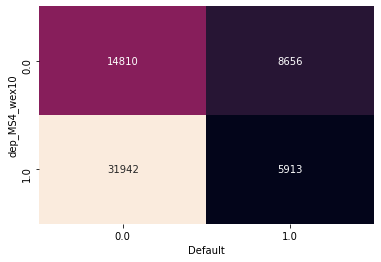

In [13]:
plotdf=pd.crosstab(data['dep_MS4_wex10'], data['Default'])
ax=sns.heatmap(plotdf, annot=True, fmt='g', cbar=False)    #axes.plot(vc)
plt.show()
#print (type(axes))


In [14]:
input_dataframe = data
INPUT_DATAFRAME = input_dataframe

LABEL_NAMES = label_names
PROTECTED_ATTRIBUTE_NAMES = protected_attribute_names
PRIVILEGED_GROUPS = privileged_groups
UNPRIVILEGED_GROUP = unprivileged_groups

**Extracting the key and value from declared dictionary**

In [15]:
protected_attribute_name = list(UNPRIVILEGED_GROUP[0].keys())[0]
privileged_group_protected_attribute_value = PRIVILEGED_GROUPS[0][protected_attribute_name]
unprivileged_group_protected_attribute_value = UNPRIVILEGED_GROUP[0][protected_attribute_name]

**Missing value impuation for modelling**

In [16]:
datatest=data
datatest['MonthlyPayment'].fillna((datatest['MonthlyPayment'].mean()), inplace=True)
datatest['ExpectedLoss'].fillna((datatest['ExpectedLoss'].mean()), inplace=True)
datatest['ProbabilityOfDefault'].fillna((datatest['ProbabilityOfDefault'].mean()), inplace=True)
datatest['DebtToIncome'].fillna((datatest['DebtToIncome'].mean()), inplace=True)
datatest['FreeCash'].fillna((datatest['FreeCash'].mean()), inplace=True)
datatest['LossGivenDefault'].fillna(0, inplace=True)

In [17]:
target=['Default']

In [18]:
choice = "NrOfDependantslessthan3"

#"NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0'

----

<a id="R"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Reject option classifier</span>
</div>

Let ${Y} ∈ ({Y^+}, {Y^-})$ be the actual labels with ${Y^+}$ being favourable class and ${Y^-}$ being unfavourable class belonging to dataset {${X_i}, {Y_i}$} with $N$ data points. Lets ${S}$ be protected features with ${S_d}$ be disadvantegous group / unprivileged group and ${S_a}$ being advantegous group / privileged group. Let $\mathbf{w}$ be the base classifier.

here we would like to minimize $\mathbb{P}({Y}={Y^+} \mid {S}={S_a}) - \mathbb{P}({Y}={Y^+} \mid {S}={S_d})$

Thus the posterior probability of any classifier can be given as $\mathbb{P}({Y}|{X})$. Here if $\mathbb{P}({Y^+}|{X})$ is higher (either close to 1 or 0) then the label assigned would be certain and hard (or vice versa - in case of probability near 0.5)

In such a scenario, [Reject Option Classifier](https://mine.kaust.edu.sa/Documents/papers/ICDM_2012.pdf) (ROC) is implemented for the labels with probability falling into critical region defined as

$max [\mathbb{P}({Y^+}\mid{S}), 1-\mathbb{P}({Y^+}\mid{S})] \leq {\theta}$

${\text{subject to}}$ 0.5<$\theta$<1 : called critical region

The [algorithm](https://github.com/cosmicBboy/themis-ml/blob/master/themis_ml/postprocessing/reject_option_classification.py), for all probabilities outside critical region the label would be unchanged but for probability falling into criticsal region the label assignment would be conducted as per the below rule:

if the ${r_i} ∈ {S_d}$ then label would be ${Y^+}$ and if ${r_i} ∈ {S_a}$ then label would be ${Y^-}$, , here ${r_i}$ are predicted probabilities.

This concept would well work for multiple (ensemble) classifier $\mathbf{w_k (w_1, w_2,..w_k)}$ with posterior probability defined as $\mathbb{P}({Y}, \mathbf{w_k}|{X})$.

In [19]:
datatest.columns

Index(['Unnamed: 0', 'Age', 'AppliedAmount', 'DebtToIncome', 'ExpectedLoss',
       'LiabilitiesTotal', 'FreeCash', 'IncomeFromChildSupport',
       'IncomeFromFamilyAllowance', 'IncomeFromLeavePay',
       ...
       'VerificationType_3.0', 'VerificationType_4.0',
       'WorkExperience_10To15Years', 'WorkExperience_15To25Years',
       'WorkExperience_2To5Years', 'WorkExperience_5To10Years',
       'WorkExperience_LessThan2Years', 'WorkExperience_MoreThan25Years',
       'Young', 'dep_MS4_wex10'],
      dtype='object', length=207)

In [20]:
dataacf = datatest[['Default','Age', 'AppliedAmount', 'ExpectedLoss', 'LiabilitiesTotal', 'IncomeTotal', 
                    'Interest', 'LoanDuration', 'MonthlyPayment',
"NrOfDependantslessthan3", 'MaritalStatus_1.0', 'MaritalStatus_3.0', 'MaritalStatus_4.0', 'dep_MS4_wex10']]


y=dataacf['Default']
x=dataacf.drop(columns=['Default'])


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=6666)
clf_full = LogisticRegression(random_state=0, solver='liblinear',
                              multi_class='ovr').fit(X_train, y_train)
y_pred=clf_full.predict(X_test)
y_pred_prob=clf_full.predict_proba(X_test)[:,0]
print("Accuracy of the full model:", clf_full.score(X_test, y_test))

Accuracy of the full model: 0.770974317162658


- pval = 0, upval = 1
- fav = 0, high prob
- unfav = 1, low prob

In [21]:
def Rjopt(DECISION_THRESHOLD, theta, choice, pred_prob, X_test, pval = 0, demote = True):
    upval = int(not pval) #Unprivileged
    pred_prob = y_pred_prob.copy() #probabilities of getting output as 0 or favourable (high probability high case of 0 or fav)
    s = X_test[choice]
    
    flip_candidates = np.ones_like(pred_prob).astype(bool) if demote else s == upval #unprivileged group
    np.sum(flip_candidates)
    
    under_theta_index = np.where(
            (np.abs(pred_prob - 0.5) < theta) & flip_candidates) 
    #finding unprivileged & unfavourable within the threshold limit as defined by theta
    
    pred_prob[under_theta_index] = 1 - pred_prob[under_theta_index] #flipping the probabilities
    
    rocdata = pred_prob.copy()
    rocbin=np.where(rocdata > DECISION_THRESHOLD, 0, 1)
    
    fpr, tpr, _ = roc_curve(y_test, rocdata, pos_label=0)
    print('ROC:', auc(fpr, tpr))


    fpr, tpr, _ = roc_curve(y_test, y_pred_prob, pos_label=0)
    print('base:', auc(fpr, tpr))
    
    
    
    return rocbin, pred_prob

'MaritalStatus_3.0' #Single
D_Boundary = 0.5
theta = 0.1
penalise = False
pval = 0
upval = int(not pval) #Unprivileged

------------

'MaritalStatus_1.0' #Married
D_Boundary = 0.5
theta = 0.01
penalise = True
pval = 0
upval = int(not pval) #Unprivileged


-------
'MaritalStatus_4.0' #Divorced

D_Boundary = 0.5
theta = 0.1
penalise = True
pval = 1
upval = int(not pval) #Unprivileged

--------------
'NrOfDependantslessthan3'

D_Boundary = 0.5
theta = 0.1
penalise = False
pval = 1
upval = int(not pval) #Unprivileged

------------------
dep_MS4_wex10
D_Boundary = 0.5
theta = 0.1
penalise = True
pval = 1
upval = int(not pval) #Unprivileged

'MaritalStatus_1.0' #Married
'MaritalStatus_3.0' #Single
'MaritalStatus_4.0' #Divorced

In [22]:
#choice = 'dep_MS4_wex10' 
s= choice = 'dep_MS4_wex10' #'MaritalStatus_4.0' #'NrOfDependantslessthan3' 
#MaritalStatus_4.0' #'dep_MS4_wex10' # 'NrOfDependantslessthan3' #Single 'MaritalStatus_3.0', dep_MS4_wex10

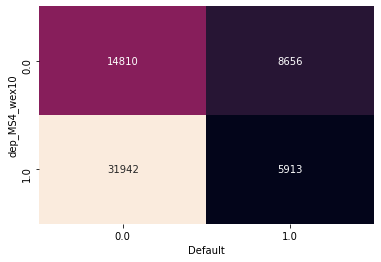

In [23]:
plotdf=pd.crosstab(data[choice], data['Default'])
ax=sns.heatmap(plotdf, annot=True, fmt='g', cbar=False)    #axes.plot(vc)
plt.show()
#print (type(axes))

In [24]:
D_Boundary = 0.5
theta = 0.1
penalise = True
pval = 1
upval = int(not pval) #Unprivileged

In [25]:
pred_prob = y_pred_prob.copy() #probabilities of getting output as 0 or favourable (high probability high case of 0 or fav)

In [26]:
roc=pd.DataFrame()
roc_df = pd.DataFrame(pred_prob, columns=['pred_prob'])
roc_df['y_pred_original'] = y_pred_prob
roc_df['y_pred'] = y_pred
roc_df['y_test'] = y_test.reset_index(drop=True)
roc_df['S'] = X_test[choice].reset_index(drop=True)
roc_df['id']=roc_df.index
roc_df.head()

,pred_prob,y_pred_original,y_pred,y_test,S,id
0,0.851482,0.851482,0.0,1.0,1.0,0
1,0.828825,0.828825,0.0,0.0,1.0,1
2,0.831863,0.831863,0.0,0.0,1.0,2
3,0.665093,0.665093,0.0,0.0,0.0,3
4,0.767699,0.767699,0.0,1.0,1.0,4


In [27]:
if penalise==True:
    RO_df = roc_df[(np.abs(pred_prob - 0.5) < theta)]
else:
    RO_df = roc_df[(np.abs(pred_prob - 0.5) < theta) & (y_pred==fav)]


In [28]:
RO_df.head()

,pred_prob,y_pred_original,y_pred,y_test,S,id
6,0.499860,0.499860,1.0,0.0,0.0,6
7,0.507807,0.507807,0.0,0.0,0.0,7
10,0.476438,0.476438,1.0,1.0,0.0,10
11,0.596510,0.596510,0.0,1.0,0.0,11
15,0.595882,0.595882,0.0,0.0,0.0,15


In [29]:
pval_fav = RO_df[(RO_df['S']==pval) & (RO_df['y_pred']==fav)]
pval_ufav = RO_df[(RO_df['S']==pval) & (RO_df['y_pred']==unfav)]
upval_fav = RO_df[(RO_df['S']==upval) & (RO_df['y_pred']==fav)]
upval_ufav = RO_df[(RO_df['S']==upval) & (RO_df['y_pred']==unfav)]

In [30]:
pval_fav['pred_prob'] = 1- pval_fav['pred_prob']
upval_ufav['pred_prob'] = 1-upval_ufav['pred_prob']

In [31]:
RO_changed = pd.concat([pval_fav, pval_ufav, upval_fav, upval_ufav])

In [32]:
RO_changed.head()

,pred_prob,y_pred_original,y_pred,y_test,S,id
53,0.480051,0.480051,1.0,0.0,1.0,53
5906,0.460625,0.460625,1.0,0.0,1.0,5906
7,0.507807,0.507807,0.0,0.0,0.0,7
11,0.596510,0.596510,0.0,1.0,0.0,11
15,0.595882,0.595882,0.0,0.0,0.0,15


In [33]:
df = roc_df

In [34]:
df.loc[list(RO_changed.index), 'pred_prob']=RO_changed['pred_prob']

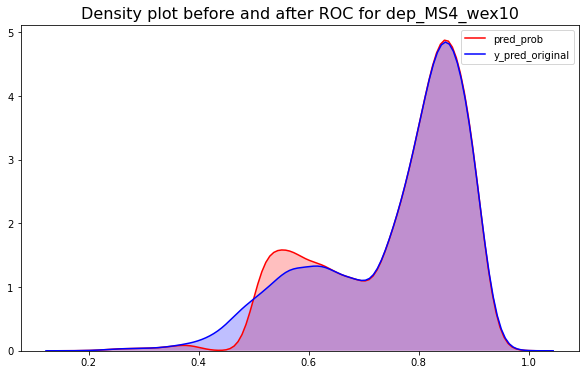

In [35]:
plt.figure(figsize=(10,6))
p1=sns.kdeplot(df['pred_prob'], shade=True, color="r")
p1=sns.kdeplot(df['y_pred_original'], shade=True, color="b")
plt.title('Density plot before and after ROC for {}'.format(choice), fontsize=16)
plt.show()

In [36]:
df['rocdata']=df['pred_prob'].copy()
df['rocbin']=np.where(df['rocdata'] > 0.5, 0, 1)

In [37]:
from sklearn.metrics import roc_curve, auc
print (choice)
fpr, tpr, _ = roc_curve(df['y_test'], df['y_pred_original'].values, pos_label=0)
ROC = auc(fpr, tpr)
print('Original:', ROC)


fpr, tpr, _ = roc_curve(df['y_test'], df['pred_prob'].values, pos_label=0)
base = auc(fpr, tpr)
print('After ROC:', base)

print('ratio', base/ROC)

print ()


dep_MS4_wex10
Original: 0.6865328981869541
After ROC: 0.6855226155029621
ratio 0.9985284278631658



In [38]:
tn_up, fp_up, fn_up, tp_up = confusion_matrix(df['y_test'][df['S']==upval], df['rocbin'][df['S']==upval]).ravel()
tn_p, fp_p, fn_p, tp_p = confusion_matrix(df['y_test'][df['S']==pval], df['rocbin'][df['S']==pval]).ravel()
ROC = acfmetrics(tn_up, fp_up, fn_up, tp_up, tn_p, fp_p, fn_p, tp_p)

tn_up, fp_up, fn_up, tp_up = confusion_matrix(df['y_test'][df['S']==upval], df['y_pred'][df['S']==upval]).ravel()
tn_p, fp_p, fn_p, tp_p = confusion_matrix(df['y_test'][df['S']==pval], df['y_pred'][df['S']==pval]).ravel()
Fullmodel = acfmetrics(tn_up, fp_up, fn_up, tp_up, tn_p, fp_p, fn_p, tp_p)

In [39]:
headers=["Eq Opportunity", "Eq Of Odds", "Precision", 
         "Demo Parity", "Avg Odds Diff", "Pred equality", "Pred Parity", "TPR", 
         'cost (in Mn)']
ROC={'Metrics':headers, 
             'Full Model':list(Fullmodel), 'ROC Fair Model':list(ROC)}
ROC_table=pd.DataFrame.from_dict(ROC)

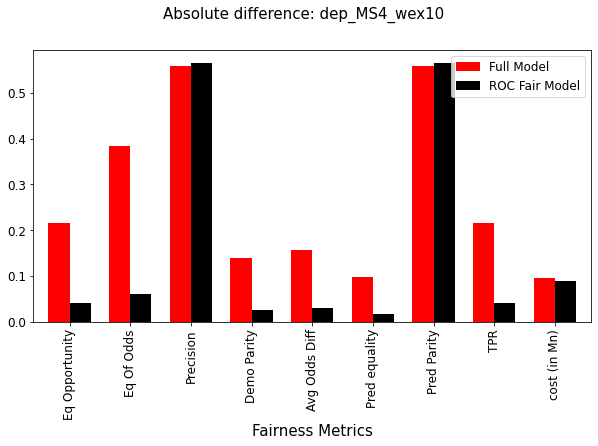

In [40]:
ax = ROC_table.plot.bar(x='Metrics', rot=90, width = 0.7, color=['red', 'black'], figsize=(10,5), fontsize=12)
plt.suptitle('Absolute difference: {}'.format(choice),  
             fontsize=15, y=1)

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)

ax.set_xlabel('Fairness Metrics', fontsize=15)
plt.show()

In [41]:
def thetha(y_test, y_pred_prob, X_test, protected_label, pval = 1, DECISION_THRESHOLD = 0.5, demote = False):
    upval = int(not pval) #Unprivileged
    
    pred_prob = y_pred_prob.copy() #probabilities of getting output as 0 or favourable (high probability high case of 0 or fav)
    s = X_test[protected_label]
    
    flip_candidates = np.ones_like(pred_prob).astype(bool) \
            if demote else s == upval #unprivileged group
    
    thetha = np.arange(0.01, 0.99, 0.01)
    
    ROC=[]
    cnt = 0
    for t1 in thetha:
        under_theta_index = np.where(
            (np.abs(pred_prob - 0.5) < t1) & flip_candidates & (pred_prob<0.5))
        
        pred_prob[under_theta_index] = 1-pred_prob[under_theta_index] #flipping the probabilities
        
        rocdata=pred_prob.copy()
        rocbin=np.where(rocdata > 0.5, 0, 1)
        
        tn_up, fp_up, fn_up, tp_up = confusion_matrix(y_test[s==upval], rocbin[s==upval]).ravel()
        tn_p, fp_p, fn_p, tp_p = confusion_matrix(y_test[s==pval], rocbin[s==pval]).ravel()
        results = acfmetrics(tn_up, fp_up, fn_up, tp_up, tn_p, fp_p, fn_p, tp_p)
        
        #print(results)
        
        ROC.append(results)
        
    
    return ROC

In [42]:
jj=thetha(df['y_test'].values, df['y_pred_original'].values, X_test, choice, pval = pval)


In [43]:
thetha = np.arange(0.01, 0.99, 0.01)
df_ROC = pd.DataFrame(jj, columns=["Eq of Opportunity", "Eq Of Odds", "Precision", 
         "Demographic Parity", "Avg Odds Diff", "Predictive equality", "Predictive Parity", "True Positive Rate", 
         'cost in Mn'])
df_ROC['thetha'] = thetha
#df_ROC.head(8).T

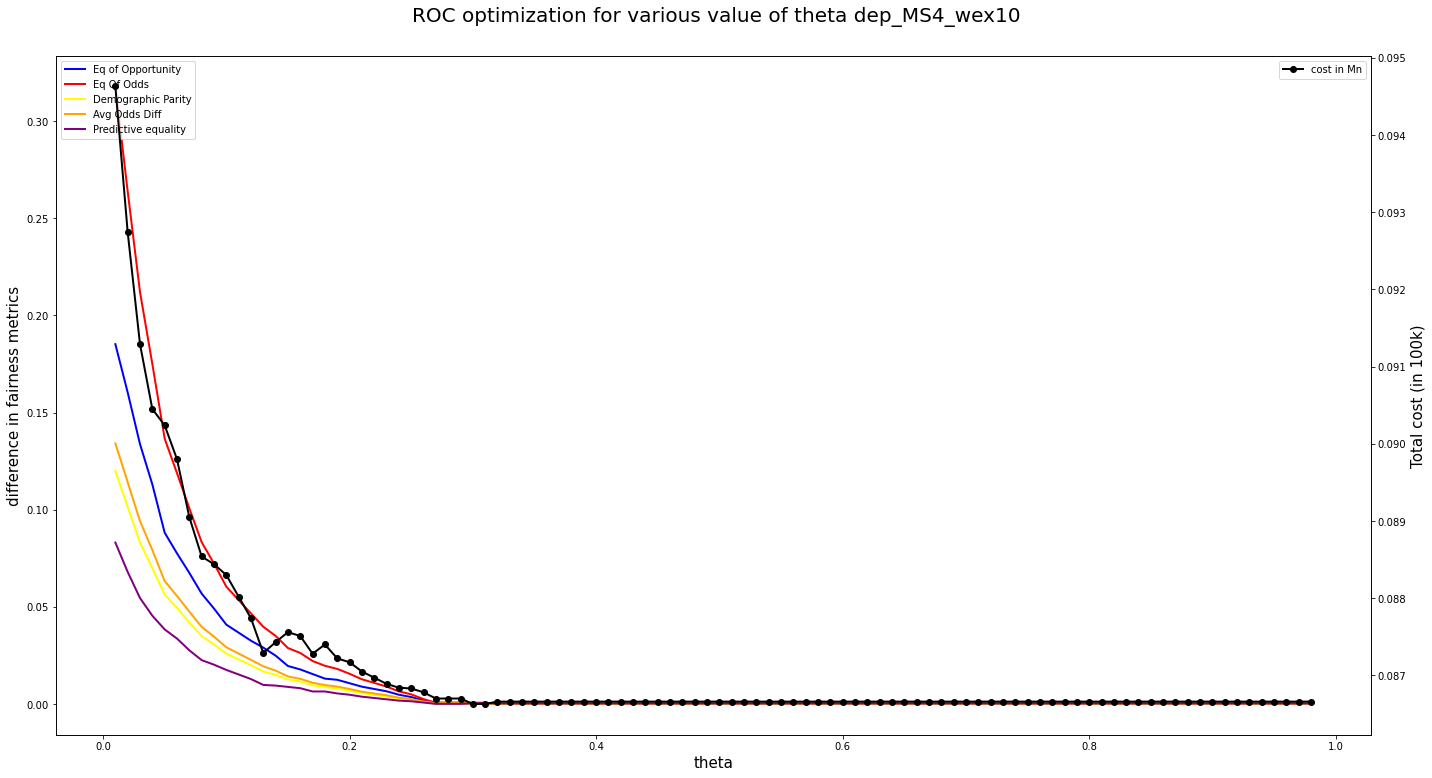

In [44]:

fig, ax1 = plt.subplots(figsize=(20,10))
fig.suptitle('ROC optimization for various value of theta {}'.format(choice), fontsize=20, y=1.05)


ax1.plot( 'thetha', 'Eq of Opportunity', data=df_ROC, marker='', color='blue', linewidth=2)
ax1.plot( 'thetha', 'Eq Of Odds', data=df_ROC, marker='', color='red', linewidth=2)
ax1.plot( 'thetha', 'Demographic Parity', data=df_ROC, marker='', color='yellow', linewidth=2)
ax1.plot( 'thetha', 'Avg Odds Diff', data=df_ROC, marker='', color='orange', linewidth=2)
ax1.plot( 'thetha', 'Predictive equality', data=df_ROC, marker='', color='purple', linewidth=2)

ax2 = ax1.twinx() 

ax2.plot( 'thetha', 'cost in Mn', data=df_ROC, marker='o', color='black', linewidth=2)

patches, labels = ax1.get_legend_handles_labels()
ax1.legend(patches, labels, loc='upper left', fontsize=10)

patches, labels = ax2.get_legend_handles_labels()
ax2.legend(patches, labels, loc='upper left', fontsize=14)

ax1.set_ylabel('difference in fairness metrics', fontsize=15)
ax2.set_ylabel('Total cost (in 100k)', fontsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()

ax1.set_xlabel('theta', fontsize=15)
plt.show()

<div class="alert alert-block alert-success">
<b>Inference:</b>
The implementation of ROC on sensitive feature Single (MaritialStatus\_3.0) shows that the fairness metrics like equality of opportunity, equalised odds, demographic parity, average odds difference, predictive equality, TPR shows very little discrimination. The cost seems to have gone don by new notches too. The optimization graphs further shows that optimal value of theta that can be considered. Its vivid that the optimal theta to minimize all fairness metrics and cost would be between 0.1 and 0.2.
    The first plot on top shows the scatter plot for actual predicted probabilities and predicted probabilities after ROC calibration. The second plot highlights the sensitive features and it can be that only unprivileged class has got affected. The third plot shows distribution for  actual predicted probabilities and predicted probabilities after ROC calibration. The first below at bottom show change different fairness metrics (and total cost) before and after  ROC calibration while the last plot shows the fairness metrics and total cost for various values of theta
</div>